In [1]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import utils

In [2]:
def cosine_distance(pose1, pose2):
    # Find the cosine similarity
    cossim = pose1.dot(np.transpose(pose2)) / (np.linalg.norm(pose1) * np.linalg.norm(pose2))

    # Find the cosine distance
    cosdist = (1 - cossim)

    return cosdist

# Weighted Distance Metric
# Input: L2 normized pose vectors, and confidence scores for each point in pose 1
# Output: Weighted distance between the two vectors
def weight_distance(pose1, pose2, conf1):
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||pose1 - pose2||)
    #= sum1 * sum2

    # Compute first summation
    sum1 = 1 / np.sum(conf1)

    # Compute second summation
    sum2 = 0
    for i in range(len(pose1)):
        conf_ind = math.floor(i / 2) # each index i has x and y that share same confidence score
        sum2 += conf1[conf_ind] * abs(pose1[i] - pose2[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

from nltk.cluster.util import cosine_distance
from nltk.cluster.util import weight_distance

In [3]:
folder_path = 'D:/data/women/upperbody/person3/'
img1_path = '598_tshirts.jpg'
img2_path = '592_tshirts.jpg'
img3_path = '577_tshirts.jpg'

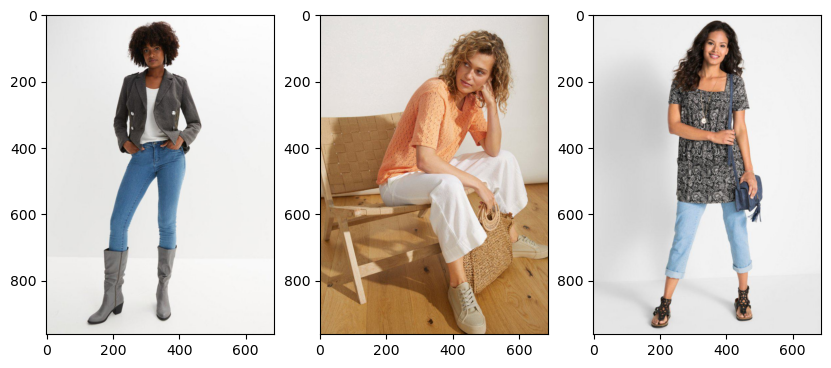

In [4]:
frame = cv.imread('D:/data/women/upperbody/person3/1415_jacken-leicht.jpg') #ideal pose - example for comparison
frame2 = cv.imread('D:/data/women/upperbody/person3/1076_pullover.jpg') #bad pose
frame3 = cv.imread(folder_path + img3_path) #good pose

# Ensure images are the same size
hi = min(frame.shape[0], frame2.shape[0])
wi = min(frame.shape[1], frame2.shape[1])
frame1 = cv.resize(frame, (wi,hi))
frame2 = cv.resize(frame2, (wi,hi))
frame3 = cv.resize(frame3, (wi,hi))

# Visualize images
fig = plt.figure(figsize = (10,20))
plt.subplot(131)
plt.imshow(frame[:,:,::-1])
plt.subplot(132)
plt.imshow(frame2[:,:,::-1])
plt.subplot(133)
plt.imshow(frame3[:,:,::-1])

plt.show()

In [5]:
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
               "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
               ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
               ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]

In [6]:
# A default value set 
inWidth = 300
inHeight = 300

In [7]:
frameWidth = frame1.shape[1]
frameHeight = frame1.shape[0]

protoFile = "C:/Users/User/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "C:/Users/User/pose_iter_116000.caffemodel"
net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

In [8]:
def pose(frame1):
    net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
    inp = cv.dnn.blobFromImage(frame1, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False)
    net.setInput(inp)
    out = net.forward()
    
    pose1 = []
    conf1 = []
    for i in range(len(BODY_PARTS)):

        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)

        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold set to 0.1.
        pose1.append((int(x), int(y)) if conf > 0.01 else None)
        conf1.append(conf)
        
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if pose1[idFrom] and pose1[idTo]:
            cv.line(frame1, pose1[idFrom], pose1[idTo], (255, 74, 0), 3)
            cv.ellipse(frame1, pose1[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            cv.ellipse(frame1, pose1[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            cv.putText(frame1, str(idFrom), pose1[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
            cv.putText(frame1, str(idTo), pose1[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
            
           
    fig1 = plt.figure(figsize = (10,10))
    plt.imshow(frame1[:,:,::-1])
    plt.show()
    
    return pose1, conf1 

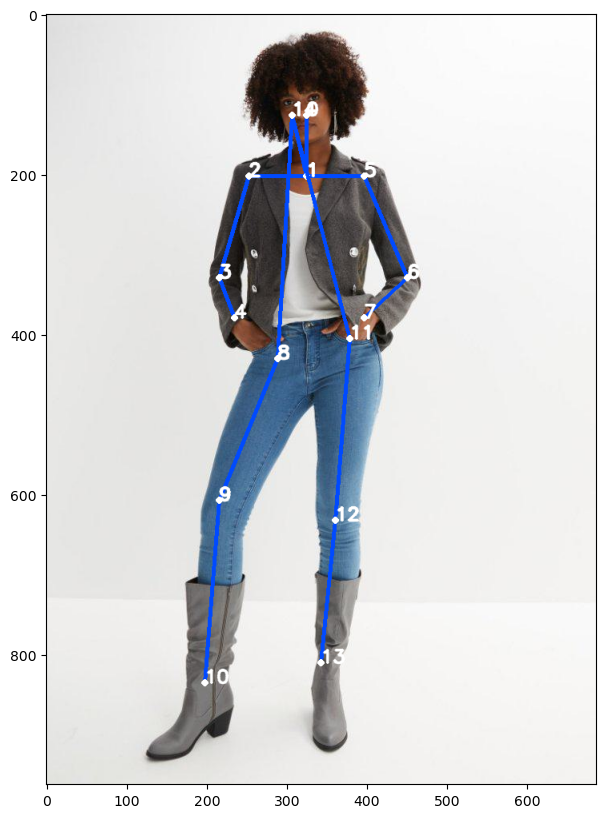

In [9]:
pose1, conf1 = pose(frame1)

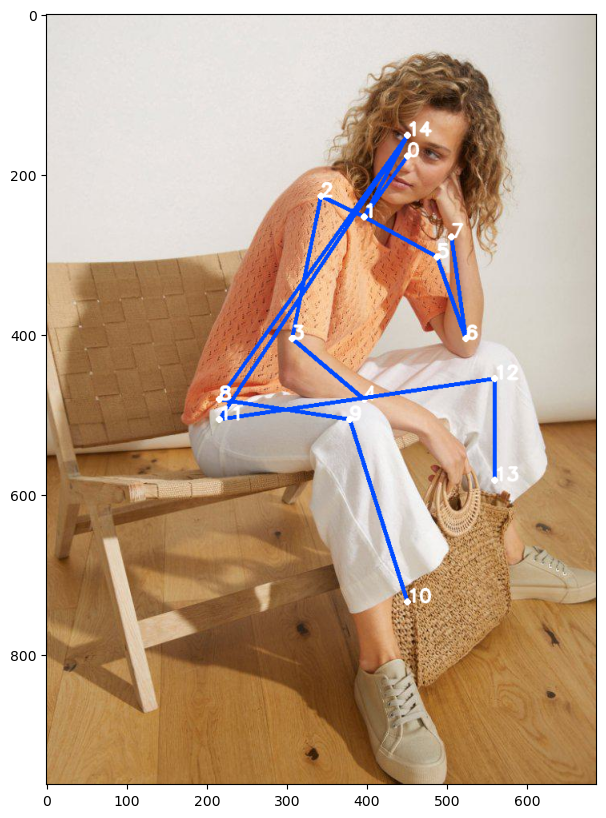

In [10]:
pose2, conf2 = pose(frame2)

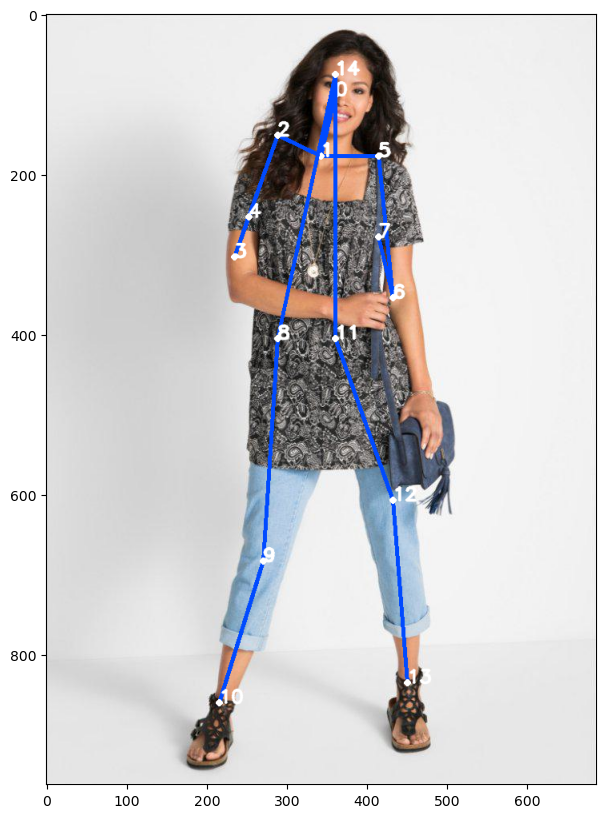

In [11]:
pose3, conf3 = pose(frame3)

In [12]:
def similarity_score(pose1, pose2):
    p1 = []
    p2 = []
    pose_1 = np.array(pose1, dtype=float)
    pose_2 = np.array(pose2, dtype=float)

    # Normalize coordinates
    pose_1[:,0] = pose_1[:,0] / max(pose_1[:,0])
    pose_1[:,1] = pose_1[:,1] / max(pose_1[:,1])
    pose_2[:,0] = pose_2[:,0] / max(pose_2[:,0])
    pose_2[:,1] = pose_2[:,1] / max(pose_2[:,1])

    # L2 Normalization
#     for joint in range(pose_1.shape[0]):
#         mag1 = float(math.sqrt(pose_1[joint][0]**2 + pose_1[joint][1]**2))
#         mag2 = float(math.sqrt(pose_2[joint][0]**2 + pose_2[joint][1]**2))

#         pose_1[joint][0] = pose_1[joint][0] / mag1
#         pose_1[joint][1] = pose_1[joint][1] / mag2
#         pose_2[joint][0] = pose_2[joint][0] / mag2
#         pose_2[joint][1] = pose_2[joint][1] / mag2

    # Turn (16x2) into (32x1)
    for joint in range(pose_1.shape[0]):
        x1 = pose_1[joint][0]
        y1 = pose_1[joint][1]
        x2 = pose_2[joint][0]
        y2 = pose_2[joint][1]

        p1.append(x1)
        p1.append(y1)
        p2.append(x2)
        p2.append(y2)

    p1 = np.array(p1)
    p2 = np.array(p2)

    # Looking to minimize the distance if there is a match
    # Computing two different distance metrics
    scoreA = cosine_distance(p1, p2)
    scoreB = weight_distance(p1, p2, conf1)

    print("Cosine Distance:", scoreA)
    print("Weighted Distance:", scoreB)

In [13]:
similarity_score(pose1, pose2)

Cosine Distance: 0.030538245092623262
Weighted Distance: 0.26518692496796215


In [14]:
similarity_score(pose1, pose3)

Cosine Distance: 0.007123753374988495
Weighted Distance: 0.12279237422357665
